### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
PATH = "datasets/"

In [3]:
datasets = []

for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        if filename.endswith(".csv"):
            full_path = os.path.join(dirname, filename)
            datasets.append(full_path)
            try:
                df_temp = pd.read_csv(full_path, nrows=0)
                print(f"File: {filename}")
                print(f"Path: {full_path}")
                print(f"Columns: {list(df_temp.columns)}")
                print("-" * 30)
            except Exception as e:
                print(f"{filename}: {e}")

File: AI Generated Essays Dataset.csv
Path: datasets/AI Generated Essays Dataset.csv
Columns: ['text', 'generated']
------------------------------
File: AI_Human.csv
Path: datasets/AI_Human.csv
Columns: ['text', 'generated']
------------------------------
File: ai_human_content_detection_dataset.csv
Path: datasets/ai_human_content_detection_dataset.csv
Columns: ['text_content', 'content_type', 'word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score', 'label']
------------------------------
File: ai_vs_human_text (1).csv
Path: datasets/ai_vs_human_text (1).csv
Columns: ['id', 'text', 'label', 'prompt', 'model', 'date']
------------------------------
File: ai_vs_human_text.csv
Path: datasets/ai_vs_human_text.csv
Columns: ['id', 'text', 'label', 'word_count', 'char_count', 

In [4]:
datasets

['datasets/AI Generated Essays Dataset.csv',
 'datasets/AI_Human.csv',
 'datasets/ai_human_content_detection_dataset.csv',
 'datasets/ai_vs_human_text (1).csv',
 'datasets/ai_vs_human_text.csv',
 'datasets/balanced_ai_human_prompts.csv',
 'datasets/processed_combined_ai_human.csv',
 'datasets/Training_Essay_Data.csv']

In [5]:
dfs = []

In [6]:
for path in datasets:
    filename = path.split("/")[-1]
    print(f"Processing: {filename}")
    
    try:
        df = pd.read_csv(path)
        if "generated" in df.columns:
            df.rename(columns={"generated": "label"}, inplace=True)
        if "text_content" in df.columns:
            df.rename(columns={"text_content": "text"}, inplace=True)
        cols_to_keep = [col for col in ["text", "label"] if col in df.columns]
        df = df[cols_to_keep]
        if "text" in df.columns and "label" in df.columns:
            print(f"Current rows: {len(df)}")
            dfs.append(df)
        else:
            print("Doesn't find any features or labels")
            
    except Exception as e:
        print(f"Error processing {filename}: {e}")

Processing: AI Generated Essays Dataset.csv
Current rows: 1460
Processing: AI_Human.csv
Current rows: 487235
Processing: ai_human_content_detection_dataset.csv
Current rows: 1367
Processing: ai_vs_human_text (1).csv
Current rows: 1000
Processing: ai_vs_human_text.csv
Current rows: 1299
Processing: balanced_ai_human_prompts.csv
Current rows: 2750
Processing: processed_combined_ai_human.csv
Current rows: 491201
Processing: Training_Essay_Data.csv
Current rows: 29145


In [7]:
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.drop_duplicates(subset=['text'], inplace=True)

In [8]:
combined_df.head()

,text,label
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


In [9]:
combined_df.shape

(491970, 2)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
%matplotlib inline

In [11]:
mapping = {
    "human": 0,
    "Human-written": 0,
    "ai": 1,
    "AI-generated": 1
}
combined_df["label"] = combined_df["label"].replace(mapping)
combined_df["label"] = combined_df["label"].astype(int)

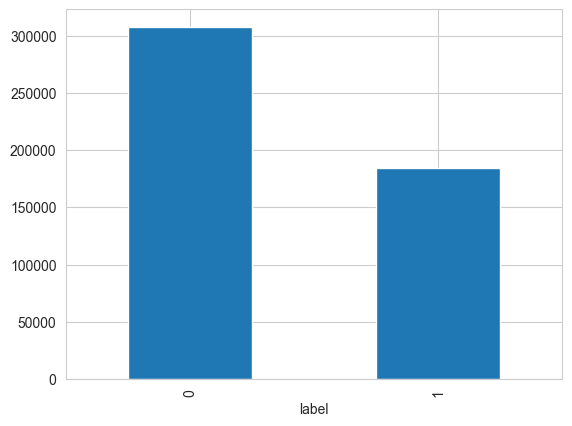

In [12]:
combined_df["label"].value_counts().plot(kind="bar")
plt.savefig("results/label_counts.png", bbox_inches="tight")
plt.show()

In [13]:
combined_df["word_count"] = combined_df["text"].str.split().str.len()

In [14]:
combined_df.head()

,text,label,word_count
0,"Machine learning, a subset of artificial intel...",1,96
1,"A decision tree, a prominent machine learning ...",1,103
2,"Education, a cornerstone of societal progress,...",1,93
3,"Computers, the backbone of modern technology, ...",1,92
4,"Chess, a timeless game of strategy and intelle...",1,110


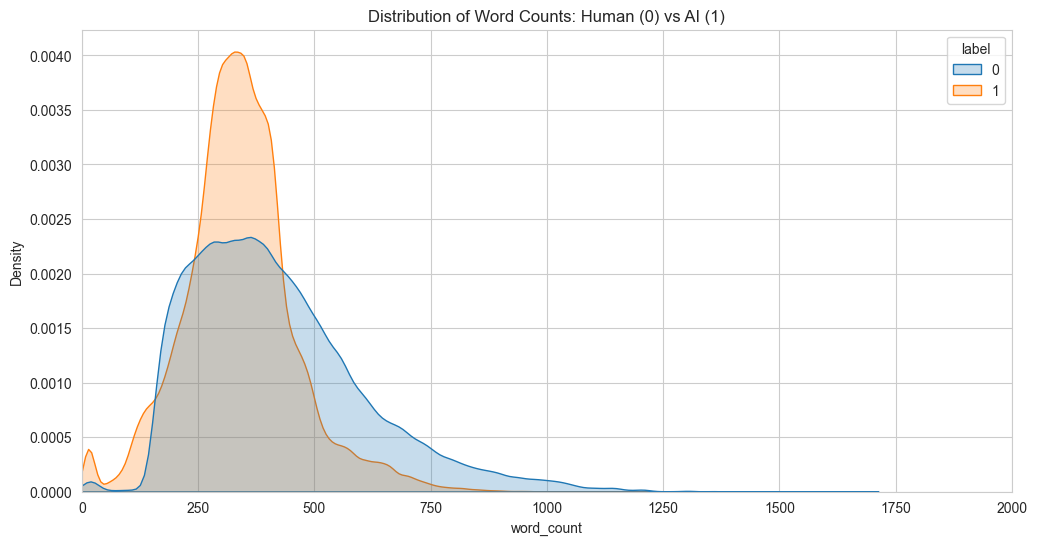

In [15]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=combined_df, x="word_count", hue="label", fill=True, common_norm=False)
plt.title("Distribution of Word Counts: Human (0) vs AI (1)")
plt.xlim(0, 2000) 
plt.savefig("results/distribution_word_counts.png", bbox_inches="tight")
plt.show()

In [16]:
combined_df.groupby("label")["word_count"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,307652.0,419.858694,188.468609,2.0,279.0,388.0,519.0,1668.0
1,184318.0,339.808212,122.111399,0.0,270.0,335.0,402.0,1238.0


In [17]:
# Remove empty/short rows (less than 10 words) 
combined_df = combined_df[combined_df["word_count"] >= 10]

In [18]:
combined_df.to_csv("datasets/processed_combined_ai_human.csv")

In [19]:
final_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
final_df.head()

,text,label,word_count
0,"Dear State Senator,\n\nI think that our presid...",0,550
1,\n\n\n\nThe Face on Mars: An Inexhaustible Sou...,1,744
2,source 1: what is the electoral collage?\n\nby...,0,592
3,"Dear state senator, I am wriitting you this le...",0,343
4,Why would you want to explore the hottest plan...,0,299


### Feature Engineering

In [21]:
import re

In [22]:
min_count = final_df["label"].value_counts().min()
df_human = final_df[final_df["label"] == 0].sample(n=min_count, random_state=42)
df_ai = final_df[final_df["label"] == 1].sample(n=min_count, random_state=42)

In [23]:
min_count

np.int64(183884)

In [24]:
df_human.head()

,text,label,word_count
358223,Why they intent Facial Action Coding System? W...,0,212
355247,I can't imagine a life or a point in time when...,0,523
1418,Online courses are unique and helpful to stude...,0,535
281384,Would you rather walk or drive a car going to ...,0,537
257873,The system of Electoral College is being alway...,0,359


In [25]:
df_ai.head()

,text,label,word_count
387832,"Dear Principal Smith, \n\nI am writing to expr...",1,366
247716,"""Day Without Cars"": A Step Towards a Greener F...",1,534
357861,The electoral college is a system used in the ...,1,489
212178,"Dear Employer,\n\nI aw writing to express WY ...",1,239
326169,"Education has always been expensive, and it is...",1,248


In [26]:
balanced_df = pd.concat([df_human, df_ai]).sample(frac=1, random_state=42)\
    .reset_index(drop=True)

In [27]:
balanced_df.head()

,text,label,word_count
0,Technology has had a profound impact on or li...,1,359
1,There is no denying that successful people usu...,1,294
2,Qonserving energy and resources is crucial fo...,1,409
3,Everyday people Kai in the car accidents becau...,0,249
4,Ideas and concepts are essential building bloc...,1,399


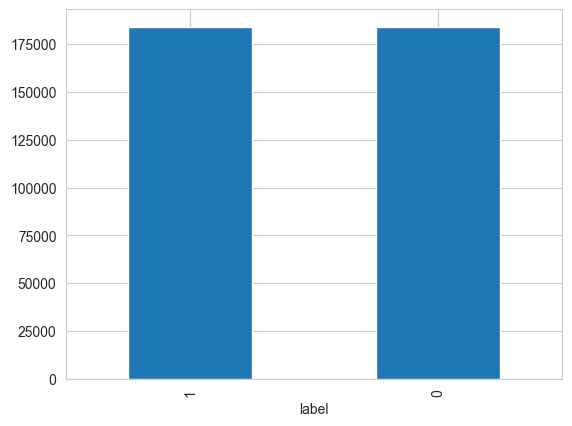

In [28]:
balanced_df["label"].value_counts().plot(kind="bar")
plt.savefig("results/balanced_value_counts.png", bbox_inches="tight")
plt.show()

In [29]:
import string

In [30]:
def clean_text(text):
    # 1. Convert to lower case
    text = str(text).lower()
    # 2. Remove square brackets []
    text = re.sub(r'\[.*?\]', '', text)
    # 3. Remove URL links (http://...)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # 4. Remove punctuation 
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    # 5. Remove newlines
    text = re.sub(r'\n', ' ', text)
    # 6. Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text


In [31]:
balanced_df["clean_text"] = balanced_df["text"].apply(clean_text)

In [32]:
balanced_df.head()

,text,label,word_count,clean_text
0,Technology has had a profound impact on or li...,1,359,technology has had a profound impact on or li...
1,There is no denying that successful people usu...,1,294,there is no denying that successful people usu...
2,Qonserving energy and resources is crucial fo...,1,409,qonserving energy and resources is crucial fo...
3,Everyday people Kai in the car accidents becau...,0,249,everyday people kai in the car accidents becau...
4,Ideas and concepts are essential building bloc...,1,399,ideas and concepts are essential building bloc...


### Model Training

In [33]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [34]:
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

In [35]:
X_train = train_df["text"].values 
X_test = test_df["text"].values
y_train = train_df["label"].values
y_test = test_df["label"].values


In [36]:
train_df.head()

,text,label,word_count
429636,"Today in class I read an article on ""Driverles...",0,311
316977,"Dear Senator [Last Name],\n\nI hope this lett...",1,472
30601,Phones and driving\n\nI believe that despite t...,0,352
244474,Driverless cars used to AE only things of imag...,0,445
429187,"Dear Senator, The topic of the Electoral colle...",0,544


In [37]:
test_df.head()

,text,label,word_count
218418,"Walking into the voting booth ""...every four y...",0,537
80500,"Dear Head,\n\nThere are many kids who want to ...",0,254
12478,"Dear Principle,\n\nPolicy 1, giving rights to ...",0,432
12063,"In recent years, there has been a growing move...",1,374
176161,In my opinion I think Mt Ms a good Idea that s...,0,225


In [38]:
tfidf = TfidfVectorizer(max_features=20000, stop_words="english")

In [39]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [40]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score

In [41]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [42]:
score = log_reg.score(X_test_tfidf, y_test)

In [43]:
score

0.9909304669129997

In [44]:
y_pred = log_reg.predict(X_test_tfidf)

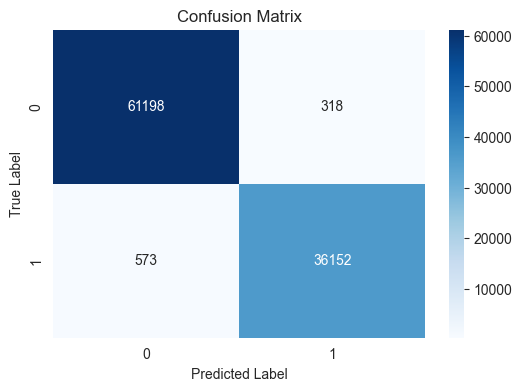

In [45]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("results/confusion_matrix.png", bbox_inches="tight")
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

y_prob = log_reg.predict_proba(X_test_tfidf)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9991765392598387


In [47]:
joblib.dump(log_reg, "saved_models/log_reg_model.pkl")
joblib.dump(tfidf, "saved_models/tfidf_vectorizer.pkl")

['saved_models/tfidf_vectorizer.pkl']

In [48]:
model = joblib.load("saved_models/log_reg_model.pkl")
tfidf = joblib.load("saved_models/tfidf_vectorizer.pkl")

In [49]:
def predict_text(text):
    text_tfidf = tfidf.transform([text])
    prediction = model.predict(text_tfidf)[0]
    probabilities = model.predict_proba(text_tfidf)[0]
    label = "AI Generated" if prediction == 1 else "Human Written"
    confidence = probabilities[1] if prediction == 1 else probabilities[0]
    
    return label, confidence * 100

In [50]:
final_df = pd.read_csv("datasets/processed_combined_ai_human.csv")

In [51]:
df = final_df.copy()

In [52]:
df.head()

,Unnamed: 0,text,label,word_count
0,0,"Machine learning, a subset of artificial intel...",1,96
1,1,"A decision tree, a prominent machine learning ...",1,103
2,2,"Education, a cornerstone of societal progress,...",1,93
3,3,"Computers, the backbone of modern technology, ...",1,92
4,4,"Chess, a timeless game of strategy and intelle...",1,110


In [53]:
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
df["char_count"] = df["text"].apply(lambda x: len(str(x)))

In [54]:
df.head()

,Unnamed: 0,text,label,word_count,char_count
0,0,"Machine learning, a subset of artificial intel...",1,96,722
1,1,"A decision tree, a prominent machine learning ...",1,103,774
2,2,"Education, a cornerstone of societal progress,...",1,93,757
3,3,"Computers, the backbone of modern technology, ...",1,92,718
4,4,"Chess, a timeless game of strategy and intelle...",1,110,827


In [55]:
print(df[df["label"] == 0]["word_count"].describe())

count    307317.000000
mean        420.309267
std         188.076288
min          10.000000
25%         280.000000
50%         388.000000
75%         519.000000
max        1668.000000
Name: word_count, dtype: float64


In [56]:
df[df["label"] == 1]["word_count"].describe()

count    183884.000000
mean        340.591792
std         121.184233
min          10.000000
25%         271.000000
50%         335.000000
75%         403.000000
max        1238.000000
Name: word_count, dtype: float64

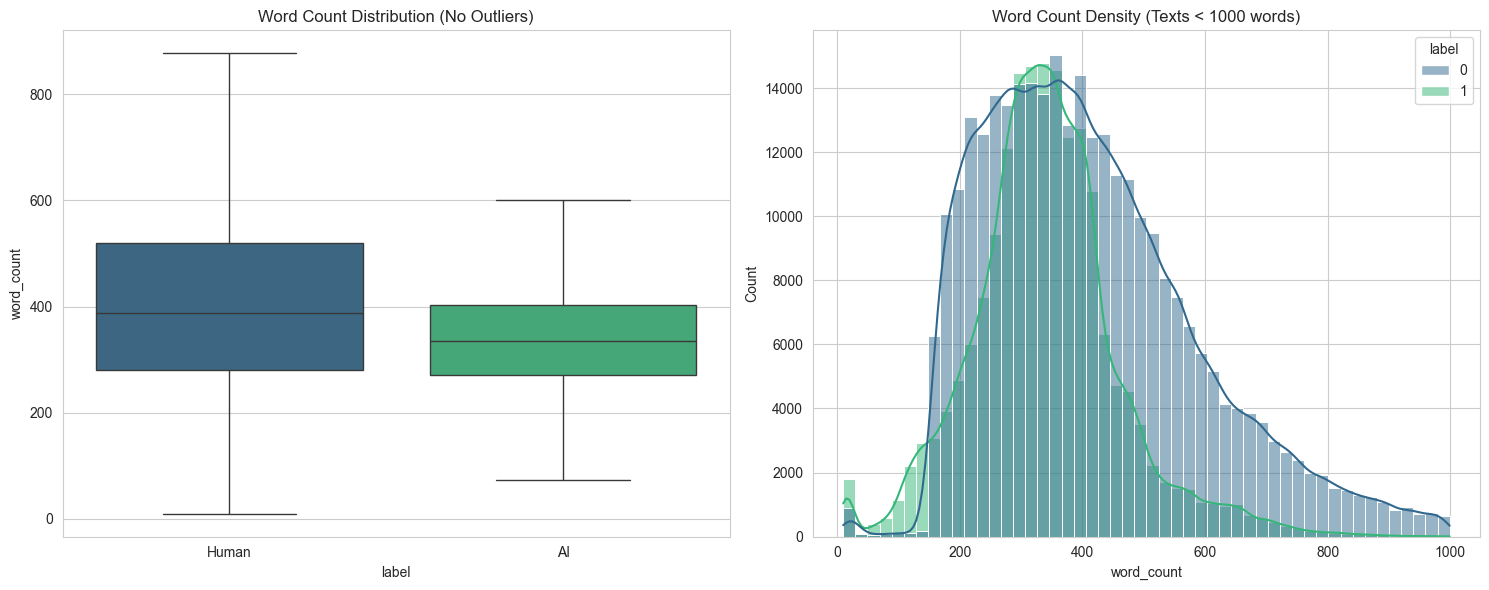

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(ax=axes[0], x="label", y="word_count", data=df, palette="viridis", showfliers=False)
axes[0].set_title("Word Count Distribution (No Outliers)")
axes[0].set_xticklabels(["Human", "AI"])
sns.histplot(ax=axes[1], data=df[df["word_count"] < 1000], x="word_count", hue="label", kde=True, palette="viridis", bins=50)
axes[1].set_title("Word Count Density (Texts < 1000 words)")
plt.savefig("results/word_count.png")
plt.tight_layout()
plt.show()

In [58]:
MIN_WORDS = 10
MAX_WORDS = 2000

In [59]:
cleaned_df = df[(df["word_count"] >= MIN_WORDS) & (df["word_count"] <= MAX_WORDS)].copy()

In [60]:
cleaned_df.head()

,Unnamed: 0,text,label,word_count,char_count
0,0,"Machine learning, a subset of artificial intel...",1,96,722
1,1,"A decision tree, a prominent machine learning ...",1,103,774
2,2,"Education, a cornerstone of societal progress,...",1,93,757
3,3,"Computers, the backbone of modern technology, ...",1,92,718
4,4,"Chess, a timeless game of strategy and intelle...",1,110,827


In [61]:
df["unique_word_count"] = df["text"].apply(lambda x: len(set(str(x).lower().split())))

In [62]:
df["lexical_diversity"] = df["unique_word_count"] / (df["word_count"] + 1e-9)

In [63]:
df.head()

,Unnamed: 0,text,label,word_count,char_count,unique_word_count,lexical_diversity
0,0,"Machine learning, a subset of artificial intel...",1,96,722,73,0.760417
1,1,"A decision tree, a prominent machine learning ...",1,103,774,85,0.825243
2,2,"Education, a cornerstone of societal progress,...",1,93,757,77,0.827957
3,3,"Computers, the backbone of modern technology, ...",1,92,718,73,0.793478
4,4,"Chess, a timeless game of strategy and intelle...",1,110,827,83,0.754545


In [64]:
from collections import Counter
import zlib
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

In [65]:
df.columns = [c.strip() for c in df.columns]

In [66]:
df.columns

Index(['Unnamed: 0', 'text', 'label', 'word_count', 'char_count',
       'unique_word_count', 'lexical_diversity'],
      dtype='object')

In [67]:
import xgboost as xgb

In [68]:
tfidf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 1), 
    stop_words="english"
)


In [69]:
X = tfidf.fit_transform(balanced_df["clean_text"])
y = balanced_df["label"]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                    stratify=y)

In [71]:
xgb_model = xgb.XGBClassifier(
    tree_method="hist",      
    n_estimators=500,        
    max_depth=6,             
    learning_rate=0.05,      
    random_state=42,
    eval_metric="logloss"
)

In [72]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [73]:
y_pred = xgb_model.predict(X_test)

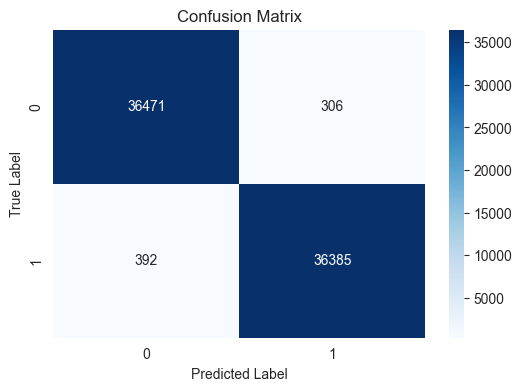

In [74]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("results/confusion_matrix_xgb.png", bbox_inches="tight")
plt.show()

In [75]:
from sklearn.metrics import classification_report

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     36777
           1       0.99      0.99      0.99     36777

    accuracy                           0.99     73554
   macro avg       0.99      0.99      0.99     73554
weighted avg       0.99      0.99      0.99     73554



In [77]:
joblib.dump(xgb_model, "saved_models/xgb_clf_model.pkl")
joblib.dump(tfidf, "saved_models/xgb_tfidf_vectorizer.pkl")

['saved_models/xgb_tfidf_vectorizer.pkl']